## 01 Exploratory Data Analysis

### Environment

##### Install from requirements.txt

In [ ]:
# Designed for Python 3.11.9
# !python -m pip install -r requirements.txt

##### Install each requirement in notebook

In [ ]:
# Alternative for running in Colab etc
!python -m pip install --upgrade pip

In [ ]:
!python -m pip install ibis-framework[duckdb] --upgrade
!pip install matplotlib=3.9.2
!pip install skforecast==0.14.0
!pip install pmdarima==2.0.4

### Import Data

##### Load Individual Datasets

In [2]:
import ibis
import pandas as pd
ibis.options.interactive = True
con = ibis.connect("duckdb://")

In [3]:
path = 'data_staged/'

inv_dataset_names = [
    'copper', 
    'corn', 
    'gold',
    'lumber',
    'natural-gas',
    'oil-wti',
    'r2000', 
    'soy',
    'sp500',
    'vix-volatility'
]

fred_dataset_names = [
    'consumer-sentiment', # US consumer sentiment, as measured by the University of Michigan
    'cpi',
    'hourly-wage',
    'house-median-price',
    'house-starts',
    'unemployment',
]

inv_datasets = {}
fred_datasets = {}

print('Trading Datasets')
for name in inv_dataset_names:
    inv_datasets[name] = ibis.read_csv(
        path + name + '.csv',
        dateformat='%m/%d/%Y')
    print(name + ': ' + str(inv_datasets[name].to_pandas().shape))

print('\nNontrading Datasets')
for name in fred_dataset_names:
    fred_datasets[name] = ibis.read_csv(
        path + name + '.csv',
        dateformat='%m/%d/%Y')
    print(name + ': ' + str(fred_datasets[name].to_pandas().shape))
    

    

Trading Datasets
copper: (4868, 7)
corn: (4819, 7)
gold: (4820, 7)
lumber: (4829, 7)
natural-gas: (4897, 7)
oil-wti: (4917, 7)
r2000: (5000, 7)
soy: (4939, 7)
sp500: (4769, 7)
vix-volatility: (4794, 7)

Nontrading Datasets
consumer-sentiment: (864, 2)
cpi: (682, 2)
hourly-wage: (224, 2)
house-median-price: (247, 2)
house-starts: (790, 2)
unemployment: (922, 2)


##### Initial Preprocessing

In [4]:
for key in inv_datasets.keys():
    #Drop unnecessary columns
    inv_datasets[key] = inv_datasets[key].drop('Vol.','Change %')

    #Convert column names to ALL CAPS
    inv_datasets[key] = inv_datasets[key].rename('ALL_CAPS')

    # Convert PRICE, OPEN, HIGH, and LOW to float64s if they are strings
    if inv_datasets[key]['PRICE'].type().is_string():
        inv_datasets[key] = inv_datasets[key].mutate(
            PRICE = inv_datasets[key]['PRICE'].replace(',','').cast('float64'))    

    if inv_datasets[key]['OPEN'].type().is_string():
        inv_datasets[key] = inv_datasets[key].mutate(
            OPEN = inv_datasets[key]['OPEN'].replace(',','').cast('float64'))   

    if inv_datasets[key]['HIGH'].type().is_string():
        inv_datasets[key] = inv_datasets[key].mutate(
            HIGH = inv_datasets[key]['HIGH'].replace(',','').cast('float64'))  

    if inv_datasets[key]['LOW'].type().is_string():
        inv_datasets[key] = inv_datasets[key].mutate(
            LOW = inv_datasets[key]['LOW'].replace(',','').cast('float64'))   

    # Add prefixes to each column based on the name of the dataset
    names_map = {
        f"{key}_{col}" : col 
            for col in inv_datasets[key].columns
            if col != 'DATE'}
    inv_datasets[key] = inv_datasets[key].rename(names_map)

    


In [ ]:
for k,v in inv_datasets.items():
    print(v.head())

In [5]:
# Fix column names in FRED data and drop excess rows
for key in fred_datasets.keys():
    #Rename second column (data) to name of dataset
    old_col_name = fred_datasets[key].columns[1]
    new_col_name = key
    fred_datasets[key] = fred_datasets[key].rename({new_col_name: old_col_name})

    #Convert timestamps to dates
    fred_datasets[key] = fred_datasets[key].mutate(
        DATE = fred_datasets[key]['DATE'].cast('date'))

    #Convert to snake-case
    fred_datasets[key] = fred_datasets[key].rename('ALL_CAPS')

    #Drop old data for efficiency
    fred_datasets[key] = fred_datasets[key].filter(fred_datasets[key].DATE.year() > 2005)




In [6]:
fred_datasets['consumer-sentiment'] = fred_datasets['consumer-sentiment'].mutate(
    CONSUMER_SENTIMENT  = fred_datasets['consumer-sentiment']['CONSUMER_SENTIMENT'].replace(',','').cast('float64'))

In [ ]:
for k,v in fred_datasets.items():
    print(k)
    print(v.head())

##### Merge Datasets

In [35]:

# Merge multiple Ibis tables on the specific key
# Adding prefixes to each column based on dataset name 
def merge_tables(
        tables_to_merge : dict[str, ibis.Table],
        join_key : str,
        join_type : str) -> ibis.Table:
    
    """
    Merge multiple Ibis tables with column name prefixing based on dataset names.

    Parameters:
    -----------
    tables_to_merge : dict[str, ibis.Table]
        Dictionary of tables to merge, with dataset names as keys
    base_table : ibis.Table, optional
        Initial table to merge additional datasets into. 
        If None, the first table in tables_to_merge is used as the base
    join_key : str, default 'DATE'
        Column name used for joining tables
    join_type : str, default 'innter'
        Type of join to perform (e.g., 'inner', 'left', 'right', 'outer')

    Returns:
    --------
    ibis.Table
        A single merged table with columns prefixed by their original dataset names, 
        joined on the specified join key using the specified join type
    
    Notes:
    ------
    - Columns with the join key are not prefixed
    - Duplicate column names are handled by prefixing with dataset names
    """
    merged_tables = None

    for dataset_name in tables_to_merge.keys():
        
        # Get current dataset
        current_dataset = tables_to_merge[dataset_name]

        #Base case
        if merged_tables is None:
            merged_tables = current_dataset 
        else:
            # Outer join the datasets on date
            merged_tables = ibis.join(
                left = merged_tables, 
                right = current_dataset,
                predicates = join_key,
                how = join_type,
                lname = '',
                rname = dataset_name+'_{name}')
            
            # Cross-fill date from new x_DATE column
            # to existing DATE column 
            # and drop extraneous x_DATE column
            col_name = dataset_name + '_DATE'
            if col_name in merged_tables.columns: 
                merged_tables = merged_tables.mutate(
                            DATE=ibis.case()
                            .when(merged_tables.DATE.isnull(), merged_tables[col_name])
                            .else_(merged_tables.DATE).end())
                merged_tables = merged_tables.drop(col_name)
                    
    return merged_tables



In [8]:
inv_data = merge_tables(
    inv_datasets, 
    join_key = 'DATE',
    join_type = 'outer')

In [8]:
inv_data.to_pandas().describe(include='all')

,DATE,copper_PRICE,copper_OPEN,copper_HIGH,copper_LOW,corn_PRICE,corn_OPEN,corn_HIGH,corn_LOW,gold_PRICE,...,soy_HIGH,soy_LOW,sp500_PRICE,sp500_OPEN,sp500_HIGH,sp500_LOW,vix-volatility_PRICE,vix-volatility_OPEN,vix-volatility_HIGH,vix-volatility_LOW
count,5293,4868.000000,4868.000000,4868.000000,4868.000000,4819.00000,4819.000000,4819.000000,4819.000000,4820.000000,...,4939.000000,4939.000000,4769.000000,4769.000000,4769.000000,4769.000000,4794.000000,4794.000000,4794.000000,4794.000000
unique,5293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2021-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.237292,3.236912,3.270922,3.201600,465.67697,465.507738,471.216974,460.121322,1381.531836,...,1137.963531,1116.586513,239.345641,239.313634,240.657981,237.844496,19.487643,19.623329,20.616360,18.653127
std,NaN,0.710250,0.710188,0.716528,0.703445,138.76600,138.757421,140.815583,136.630100,438.525822,...,274.387716,268.077197,125.416439,125.391609,125.978640,124.748330,8.876367,8.917850,9.612924,8.226817
min,NaN,1.265500,1.263500,1.309000,1.259500,214.75000,215.000000,215.500000,213.500000,495.300000,...,532.000000,526.500000,68.110000,67.950000,70.000000,67.100000,9.140000,9.010000,9.310000,8.560000
25%,NaN,2.712875,2.712375,2.735250,2.688125,366.00000,366.000000,369.750000,362.500000,1145.275000,...,933.750000,916.000000,135.110000,135.080000,135.850000,134.070000,13.540000,13.670000,14.220000,13.142500
50%,NaN,3.228000,3.227250,3.259000,3.193000,409.25000,409.500000,415.250000,404.500000,1310.800000,...,1060.500000,1041.000000,204.630000,204.350000,205.770000,203.800000,17.080000,17.210000,18.030000,16.340000
75%,NaN,3.739625,3.740125,3.778625,3.702125,575.12500,574.875000,582.875000,566.750000,1725.100000,...,1377.690000,1351.380000,310.270000,309.840000,311.840000,307.670000,22.587500,22.765000,23.847500,21.680000


In [9]:
fred_data = merge_tables(
    fred_datasets, 
    join_key = 'DATE', 
    join_type = 'outer')

In [10]:
#Bring in all dates from inv table
fred_data = merge_tables(
    tables_to_merge={
        'fred' : fred_data,
        'inv' : inv_data.select('DATE')
    },
    join_key = 'DATE',
    join_type = 'outer'
)

In [16]:
def impute_forward_fill(data: ibis.Table, sort_by : str = 'DATE') -> pd.DataFrame:
    """
    Impute missing values in time series data using the most recent previous valid data.

    Parameters:
    -----------
    data : ibis.Table
        Input time series data with a date key and numeric features
    
    Returns:
    --------
    ibis.Table
        Data table with NaNs filled using the most recent previous valid data
    """
      
    # Convert to pandas, sorted by date
    df = data.to_pandas().sort_values(by='DATE')
    
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    
    df[numeric_cols] = df[numeric_cols].ffill()

    # return dataframe with forward-filled data
    return df
    


In [28]:
# Run the forward-fill imputation - fred data
df = impute_forward_fill(
    data = fred_data,
    sort_by = 'DATE')

# Convert back to Ibis
fred_data = ibis.memtable(df)

# Filter out the early nulls
fred_data = fred_data.filter(fred_data.DATE.year() > 2006)

In [34]:
fred_data.to_pandas().head()

,DATE,CONSUMER_SENTIMENT,CPI,HOURLY_WAGE,HOUSE_MEDIAN_PRICE,HOUSE_STARTS,UNEMPLOYMENT
0,2007-01-01,96.9,3.136734,20.59,257400.0,1409.0,4.6
1,2007-01-02,96.9,3.136734,20.59,257400.0,1409.0,4.6
2,2007-01-03,96.9,3.136734,20.59,257400.0,1409.0,4.6
3,2007-01-04,96.9,3.136734,20.59,257400.0,1409.0,4.6
4,2007-01-05,96.9,3.136734,20.59,257400.0,1409.0,4.6


In [31]:
# Run the forward-fill imputation - investing.com data
df = impute_forward_fill(
    data = inv_data,
    sort_by = 'DATE')

# Convert back to Ibis
inv_data = ibis.memtable(df)

In [32]:
inv_data.to_pandas().shape

(5293, 41)

In [36]:
# Finally, merge the investing.com and FRED data
data = merge_tables(
    {
        'inv' : inv_data, 
        'fred' : fred_data,
    },
    join_key = 'DATE',
    join_type='inner')

,copper_PRICE,copper_OPEN,copper_HIGH,copper_LOW,corn_PRICE,corn_OPEN,corn_HIGH,corn_LOW,gold_PRICE,gold_OPEN,...,vix-volatility_PRICE,vix-volatility_OPEN,vix-volatility_HIGH,vix-volatility_LOW,CONSUMER_SENTIMENT,CPI,HOURLY_WAGE,HOUSE_MEDIAN_PRICE,HOUSE_STARTS,UNEMPLOYMENT
copper_PRICE,1.000000,0.997651,0.998946,0.999034,0.658346,0.657489,0.656907,0.659323,0.607262,0.606921,...,-0.210390,-0.210497,-0.209200,-0.209525,-0.455951,0.300256,0.403626,0.376366,0.243222,-0.082215
copper_OPEN,0.997651,1.000000,0.998874,0.998713,0.658745,0.658699,0.657643,0.659961,0.606936,0.607370,...,-0.205903,-0.208383,-0.204842,-0.206327,-0.456190,0.300985,0.403364,0.376271,0.243169,-0.083211
copper_HIGH,0.998946,0.998874,1.000000,0.998441,0.660126,0.659760,0.659074,0.661103,0.605268,0.605345,...,-0.197248,-0.198758,-0.196101,-0.197225,-0.463925,0.302930,0.402242,0.374872,0.240943,-0.080799
copper_LOW,0.999034,0.998713,0.998441,1.000000,0.656111,0.655504,0.654590,0.657349,0.609844,0.609821,...,-0.220566,-0.221503,-0.219603,-0.219990,-0.448427,0.299636,0.406218,0.379203,0.246507,-0.086146
corn_PRICE,0.658346,0.658745,0.660126,0.656111,1.000000,0.998058,0.999034,0.999148,0.381598,0.382184,...,0.058401,0.060141,0.048406,0.071041,-0.564992,0.268708,0.096845,0.101392,-0.044377,0.103567
corn_OPEN,0.657489,0.658699,0.659760,0.655504,0.998058,1.000000,0.999123,0.999098,0.381687,0.382540,...,0.059428,0.060266,0.049176,0.071609,-0.564595,0.269685,0.097410,0.101903,-0.044084,0.102664
corn_HIGH,0.656907,0.657643,0.659074,0.654590,0.999034,0.999123,1.000000,0.998785,0.377436,0.378104,...,0.064713,0.065868,0.054453,0.077025,-0.568568,0.266734,0.093042,0.097243,-0.047722,0.106726
corn_LOW,0.659323,0.659961,0.661103,0.657349,0.999148,0.999098,0.998785,1.000000,0.386811,0.387501,...,0.053486,0.054877,0.043395,0.065971,-0.561850,0.272753,0.102367,0.107195,-0.040317,0.099029
gold_PRICE,0.607262,0.606936,0.605268,0.609844,0.381598,0.381687,0.377436,0.386811,1.000000,0.999355,...,-0.113071,-0.108457,-0.102803,-0.113860,-0.311315,0.475713,0.825387,0.707291,0.406926,-0.173701
gold_OPEN,0.606921,0.607370,0.605345,0.609821,0.382184,0.382540,0.378104,0.387501,0.999355,1.000000,...,-0.112160,-0.107801,-0.101769,-0.113017,-0.311492,0.475635,0.825246,0.707344,0.407305,-0.174110


##### Dev/Holdout Split 

Split the data into model development (prior to 2018) and final holdout sets (2018 to present)

In [ ]:
dev_data = data
holdout_data = data

### Explore Feature Correlations

##### Feature Correlation Functions

In [42]:
import numpy as np
data.to_pandas().select_dtypes(include=np.number).corr()

,copper_PRICE,copper_OPEN,copper_HIGH,copper_LOW,corn_PRICE,corn_OPEN,corn_HIGH,corn_LOW,gold_PRICE,gold_OPEN,...,vix-volatility_PRICE,vix-volatility_OPEN,vix-volatility_HIGH,vix-volatility_LOW,CONSUMER_SENTIMENT,CPI,HOURLY_WAGE,HOUSE_MEDIAN_PRICE,HOUSE_STARTS,UNEMPLOYMENT
copper_PRICE,1.000000,0.997651,0.998946,0.999034,0.658346,0.657489,0.656907,0.659323,0.607262,0.606921,...,-0.210390,-0.210497,-0.209200,-0.209525,-0.455951,0.300256,0.403626,0.376366,0.243222,-0.082215
copper_OPEN,0.997651,1.000000,0.998874,0.998713,0.658745,0.658699,0.657643,0.659961,0.606936,0.607370,...,-0.205903,-0.208383,-0.204842,-0.206327,-0.456190,0.300985,0.403364,0.376271,0.243169,-0.083211
copper_HIGH,0.998946,0.998874,1.000000,0.998441,0.660126,0.659760,0.659074,0.661103,0.605268,0.605345,...,-0.197248,-0.198758,-0.196101,-0.197225,-0.463925,0.302930,0.402242,0.374872,0.240943,-0.080799
copper_LOW,0.999034,0.998713,0.998441,1.000000,0.656111,0.655504,0.654590,0.657349,0.609844,0.609821,...,-0.220566,-0.221503,-0.219603,-0.219990,-0.448427,0.299636,0.406218,0.379203,0.246507,-0.086146
corn_PRICE,0.658346,0.658745,0.660126,0.656111,1.000000,0.998058,0.999034,0.999148,0.381598,0.382184,...,0.058401,0.060141,0.048406,0.071041,-0.564992,0.268708,0.096845,0.101392,-0.044377,0.103567
corn_OPEN,0.657489,0.658699,0.659760,0.655504,0.998058,1.000000,0.999123,0.999098,0.381687,0.382540,...,0.059428,0.060266,0.049176,0.071609,-0.564595,0.269685,0.097410,0.101903,-0.044084,0.102664
corn_HIGH,0.656907,0.657643,0.659074,0.654590,0.999034,0.999123,1.000000,0.998785,0.377436,0.378104,...,0.064713,0.065868,0.054453,0.077025,-0.568568,0.266734,0.093042,0.097243,-0.047722,0.106726
corn_LOW,0.659323,0.659961,0.661103,0.657349,0.999148,0.999098,0.998785,1.000000,0.386811,0.387501,...,0.053486,0.054877,0.043395,0.065971,-0.561850,0.272753,0.102367,0.107195,-0.040317,0.099029
gold_PRICE,0.607262,0.606936,0.605268,0.609844,0.381598,0.381687,0.377436,0.386811,1.000000,0.999355,...,-0.113071,-0.108457,-0.102803,-0.113860,-0.311315,0.475713,0.825387,0.707291,0.406926,-0.173701
gold_OPEN,0.606921,0.607370,0.605345,0.609821,0.382184,0.382540,0.378104,0.387501,0.999355,1.000000,...,-0.112160,-0.107801,-0.101769,-0.113017,-0.311492,0.475635,0.825246,0.707344,0.407305,-0.174110


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_correlation_matrix(
        df : pd.DataFrame, 
        figsize=(15,15),
        gridsize=15,
        hexbin_cmap = 'plasma',
        dist_color = 'violet',
        dist_edge_color = 'indigo',
        scatter_color = 'indigo',
        scatter_alpha = 0.3):

    cols = df.columns
    n_cols = len(cols)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_cols, n_cols, figsize=figsize)
    
    # Create plot matrix
    for i in range(n_cols):
        for j in range(n_cols):
            ax = axes[i, j]
            
            # Diagonal: single-feature distribution
            if i == j:
                ax.hist(
                    df[cols[i]], 
                    bins=40,
                    color = dist_color,
                    edgecolor=dist_edge_color)
                ax.set_title(f'Distribution of {cols[i]}')
            
            # Lower triangle: hexbin plots
            elif j < i:
                ax.hexbin(
                        df[cols[j]], 
                        df[cols[i]], 
                        gridsize=gridsize, 
                        cmap=hexbin_cmap, 
                        mincnt=1)
                ax.set_xlabel(cols[j])
                ax.set_ylabel(cols[i])
            
            # Upper triangle: scatterplots
            else:
                ax.scatter(
                        df[cols[j]], 
                        df[cols[i]], 
                        alpha=scatter_alpha,
                        color=scatter_color,
                        edgecolor='none')
                ax.set_xlabel(cols[j])
                ax.set_ylabel(cols[i])
    
    plt.tight_layout()
    plt.show()



In [ ]:
# Example usage
df = pd.DataFrame(np.random.randn(1000, 4), columns=['A', 'B', 'C', 'D'])
plot_feature_correlation_matrix(df)

##### Feature Correlation Matrices

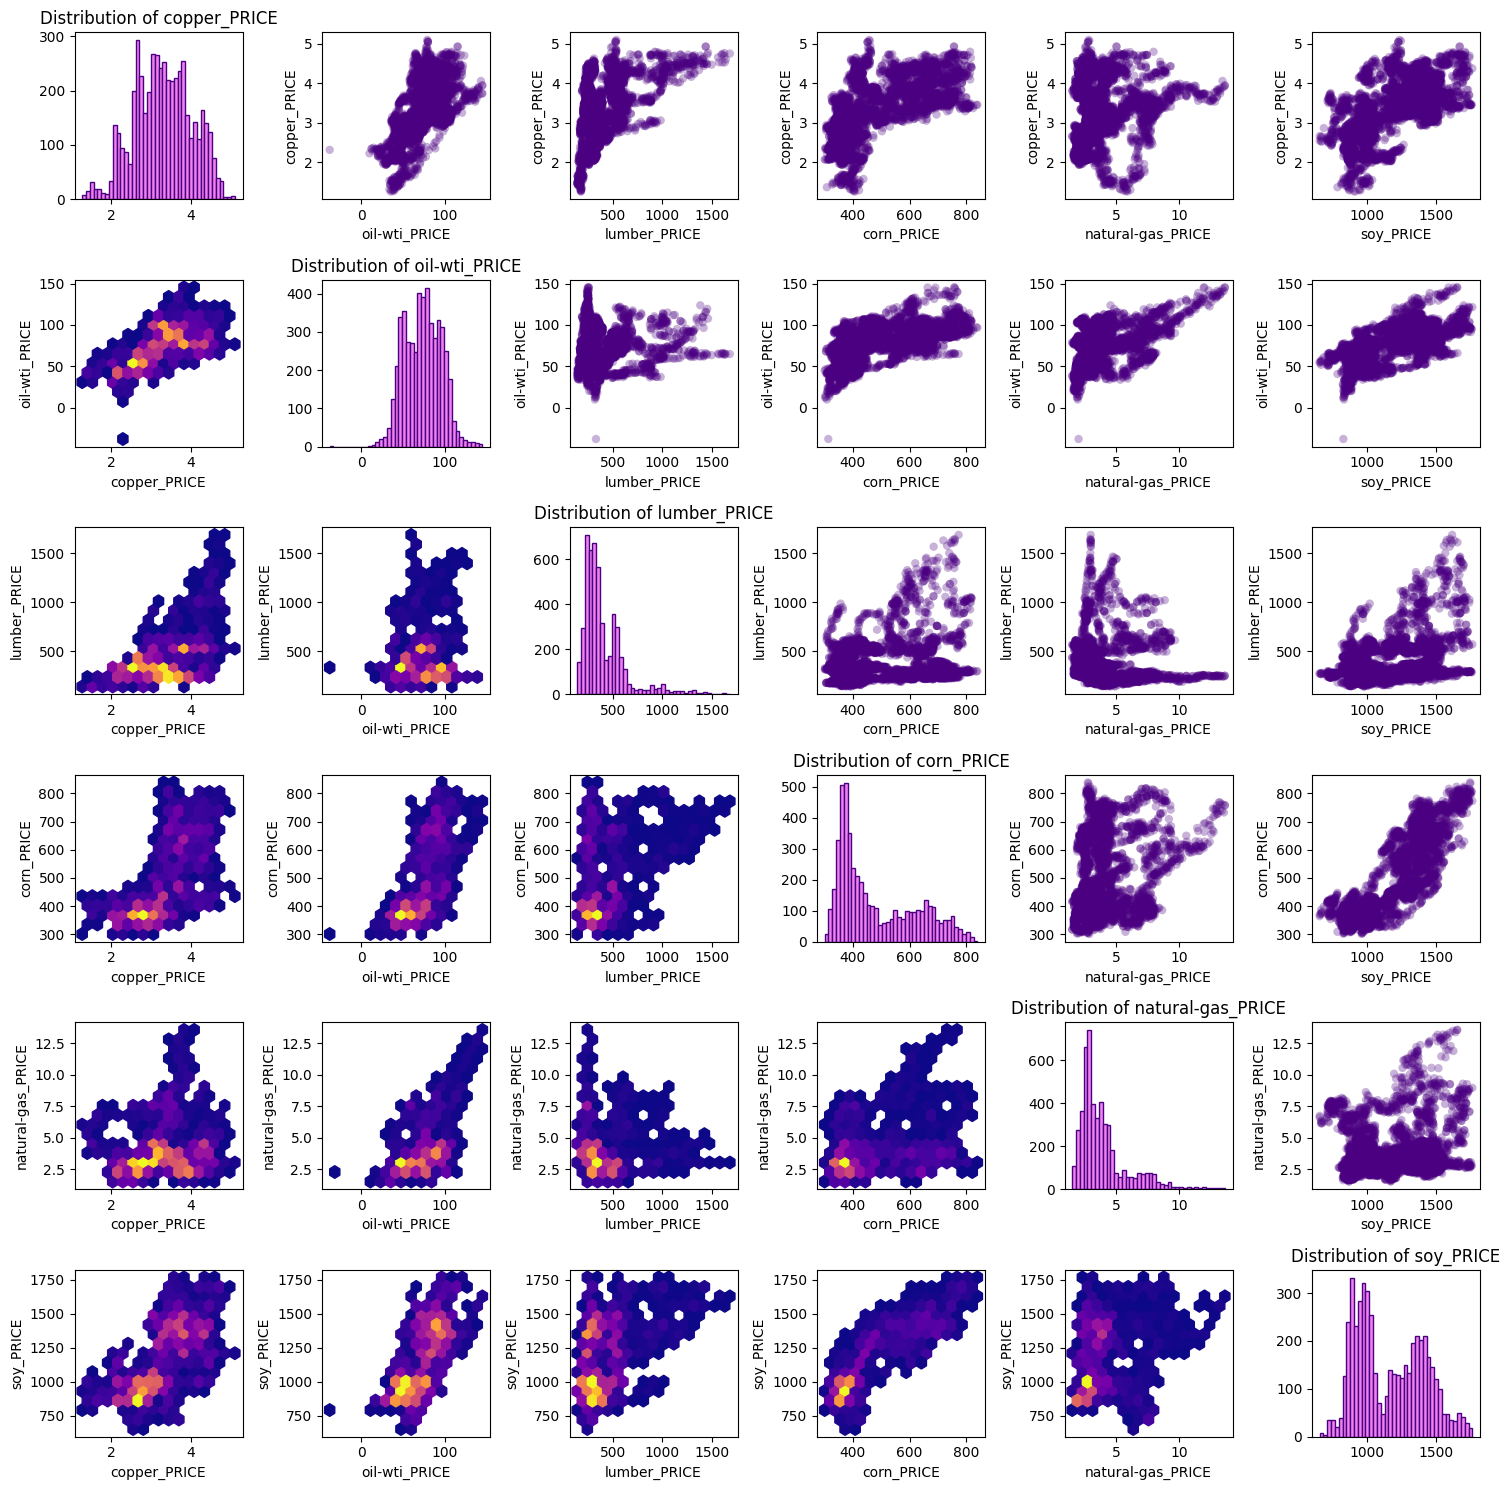

In [44]:
plot_feature_correlation_matrix(
    data.select(
        'copper_PRICE',
        'oil-wti_PRICE',
        'lumber_PRICE',
        'corn_PRICE',
        'natural-gas_PRICE',
        'soy_PRICE',
    ).to_pandas())

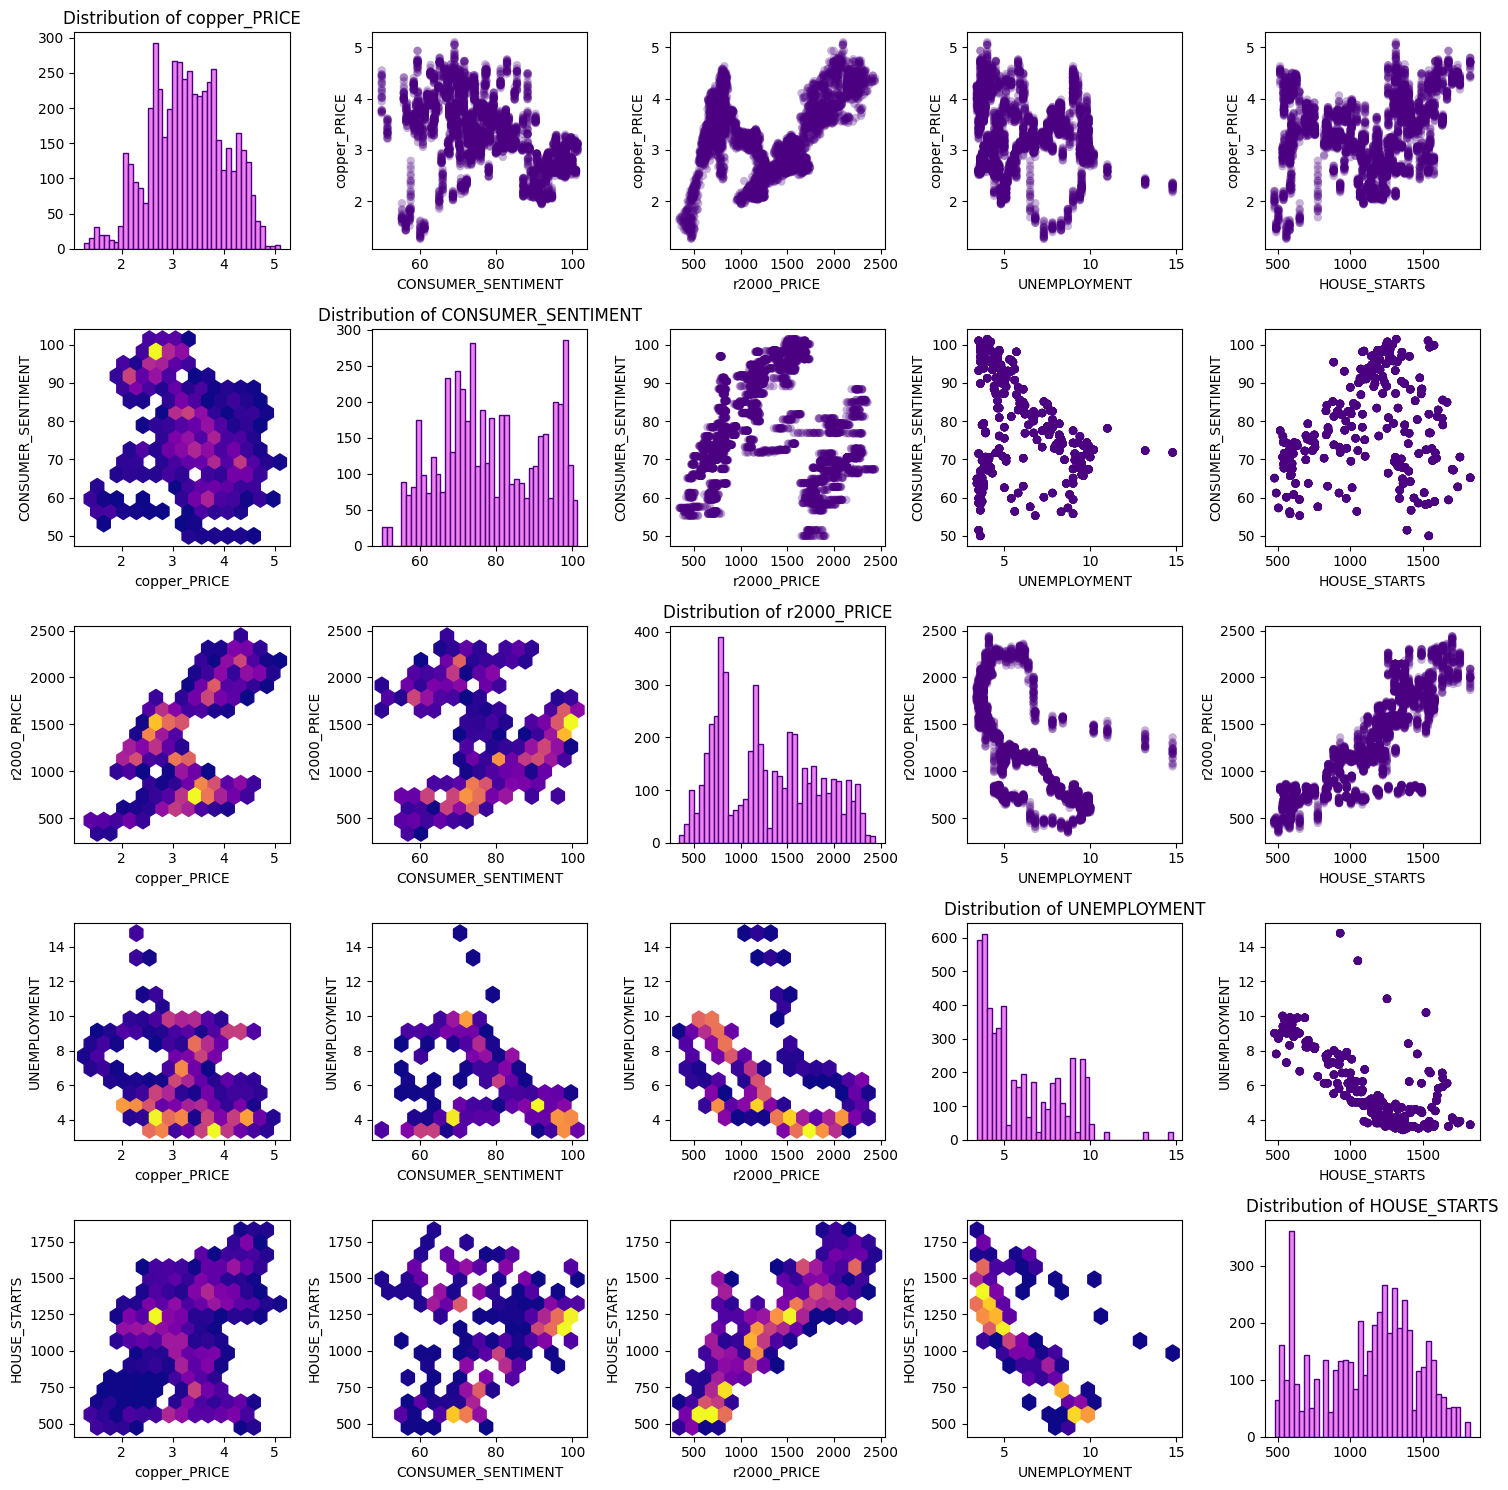

In [45]:
plot_feature_correlation_matrix(
    data.select(
        'copper_PRICE',
        'CONSUMER_SENTIMENT',
        'r2000_PRICE',
        'UNEMPLOYMENT',
        'HOUSE_STARTS'
    ).to_pandas())

### Stationarity Analysis

Features should be stationary, meaning that no significant trends or seasonal patterns should be present in the data.  The mean and variance should be consistent throughout the time period. 


[pmdarima](https://github.com/alkaline-ml/pmdarima) 


In [ ]:
import pmdarima
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import skforecast

In [ ]:
# Load/split your data
y = data
train, test = train_test_split(y, train_size=150)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

### Baseline Models

##### Training

In [ ]:
def prepare_multivariate_data(df, lags=3):
    """
    Prepare multivariate time series data for forecasting
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input time series DataFrame
    lags : int, optional (default=3)
        Number of lags to use for features
    
    Returns:
    --------
    X : numpy.ndarray
        Features matrix
    y : numpy.ndarray
        Target values
    """
    # Create lagged features for all series
    X = []
    y = []
    
    for col in df.columns:
        for i in range(len(df) - lags):
            # Create lag features
            lag_features = df.iloc[i:i+lags][col].values
            target = df.iloc[i+lags][col]
            
            X.append(lag_features)
            y.append(target)
    
    return np.array(X), np.array(y)

In [ ]:
def global_multivariate_forecast(df, forecast_horizon=5):
    """
    Perform global multi-series forecasting
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input time series DataFrame
    forecast_horizon : int, optional (default=5)
        Number of steps to forecast
    
    Returns:
    --------
    forecasts : pandas.DataFrame
        DataFrame with forecasts for each series
    """
    # Prepare data
    X, y = prepare_multivariate_data(df)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Initialize and train the forecaster
    forecaster = ForecasterAutoreg(
        regressor=LinearRegression(),
        lags=3,
        n_jobs='auto'
    )
    
    # Fit the global model
    forecaster.fit(X_train, y_train)
    
    # Forecast
    forecasts = {}
    for col in df.columns:
        # Forecast for each series
        series_forecast = forecaster.predict(forecast_horizon)
        forecasts[col] = series_forecast
    
    return pd.DataFrame(forecasts)


In [ ]:
import 

In [ ]:
#

##### Experiemental Models

In [ ]:
import pandas as pd
from piml import Experiment
from piml.models import XGB2Classifier